In [1]:
import os
import pandas as pd
import jax.numpy as jnp
import numpy as np

data_path = os.path.join("./datasets/")
np.random.seed(123)

In [2]:
# @title prepare_training_data
def prepare_training_data(data, n_obs):
  df_train = data.head(n_obs)
  df_test = data.tail(40)

  x_train, y_train, f_train = df_train, df_train.pop("y"), df_train.pop("f")
  x_test, y_test, f_test = df_test, df_test.pop("y"), df_test.pop("f")

  x_train = x_train.to_numpy()
  x_test = x_test.to_numpy()

  y_train = y_train.to_numpy().reshape(-1, 1).ravel()
  y_test = y_test.to_numpy().reshape(-1, 1).ravel()  
  return x_train, y_train, x_test, y_test

import matplotlib.pyplot as plt
def draw(dim_in, psi_est, labels = None):
    x = np.linspace(0, dim_in-1, dim_in)
    fig, ax = plt.subplots()

    ax.plot(x, psi_est, linewidth=1.0, label = "diag")
    if labels is not None:
        plt.xticks(x, labels)
    plt.legend()
    plt.show()

In [23]:
from sklearn.metrics import roc_auc_score

dataset_name = 'cont' # @param ['cat', 'cont', 'adult', 'heart', 'mi'] 
outcome_type = 'linear' # @param ['linear', 'rbf', 'matern32', 'complex']
n_obs = 200 # @param [100, 200, 500, 1000]
dim_in = 25 # @param [25, 50, 100, 200]
rep = 2 # @param 
true = np.concatenate((np.repeat(1, 5), np.repeat(0, dim_in - 5)))


data_file = f"{outcome_type}_n{n_obs}_d{dim_in}_i{rep}.csv"
data_file_path = os.path.join(data_path, dataset_name, data_file)
print(f"Data '{data_file}'", end='\t', flush=True)  

data = pd.read_csv(data_file_path, index_col=0)  
x_train, y_train, x_test, y_test = prepare_training_data(data, n_obs)

Data 'linear_n200_d25_i2.csv'	

Shapes: psi_est_all: (2000, 1, 20, 25), grad_train: (20, 25), psi_est: (25,)


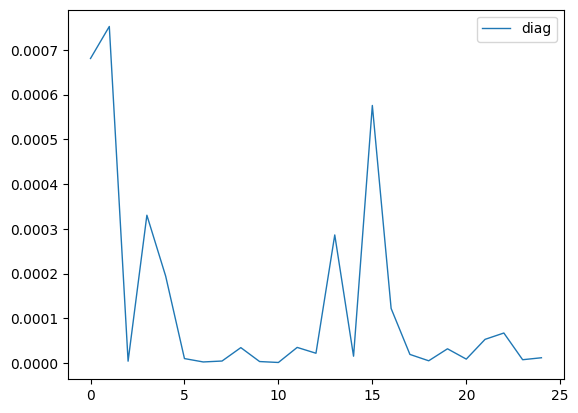

0.8000000000000002

In [24]:
from vie import get_fdt_model
fdt_out = get_fdt_model(x_train, y_train, c=0.1, sig2=0.01, n_tree=20, 
                            compute_psi=True, batch_size=1, n_samp=10, seed=0)
grad_fs = fdt_out[2]
betas = fdt_out[3]["betas"]
map_matrix = fdt_out[3]["map_matrix"]
feature = fdt_out[3]["feature"]
threshold = fdt_out[3]["threshold"]
beta = fdt_out[3]["beta"]
psi_est = np.array(grad_fs(x_test, map_matrix, feature, threshold, betas))
grad_train = np.mean(psi_est**2, axis=(0,1))
psi_test = np.median(grad_train, axis=0)

draw(dim_in, psi_test)

roc_auc_score(true, psi_test)

In [ ]:
M = 100                      # number of Mondrian trees to use
lifetime_max = 0.05          # terminal lifetime
delta = 0.01

from tqdm import tqdm
from mondrian_grad import mondrian_grad
true = np.concatenate((np.repeat(1, 5), np.repeat(0, dim_in - 5)))

score = []
c_values = [10, 5, 1, 0.5, 0.1, 0.05, 0.01]
grads_save = []
for c_value in tqdm(c_values):
    score_temp = []
    rep = 10
    for i in range(rep):
        grads, y_hat_test, feature_indices = mondrian_grad(x_train, y_train, x_test, y_test, M, lifetime_max, delta, c_value)

        #draw(dim_in, np.mean(grads**2, axis = 0))
        grads_save.append(grads**2)
        score_temp.append(roc_auc_score(true, np.mean(grads**2, axis = 0)))
    score.append(np.mean(score_temp))
draw(len(c_values), score, c_values)

(C = 3816, test error = 0.492)


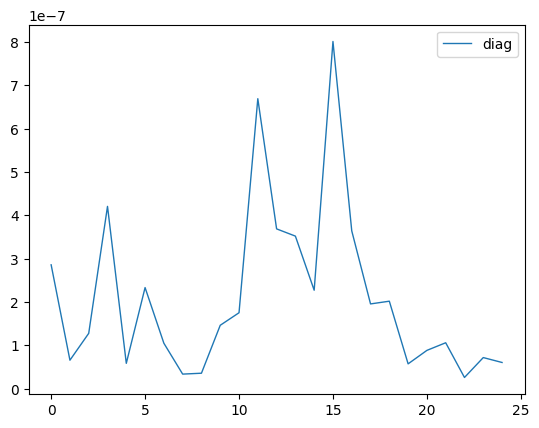

0.51

In [25]:
M = 100                      # number of Mondrian trees to use
lifetime_max = 0.05          # terminal lifetime
delta = 0.01

from mondrian_grad import mondrian_grad
true = np.concatenate((np.repeat(1, 5), np.repeat(0, dim_in - 5)))

c_value = 0.01

grads, y_hat_test, feature_indices = mondrian_grad(x_train, y_train, x_test, y_test, M, lifetime_max, delta, c_value)

draw(dim_in, np.mean(grads**2, axis = 0))
roc_auc_score(true, np.mean(grads**2, axis = 0))